##Import Libraries

In [19]:
!wget https://github.com/dejavu-fonts/dejavu-fonts/blob/master/ttf/DejaVuSans.ttf?raw=true -O DejaVuSans.ttf

--2025-09-09 12:30:39--  https://github.com/dejavu-fonts/dejavu-fonts/blob/master/ttf/DejaVuSans.ttf?raw=true
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-09 12:30:40 ERROR 404: Not Found.



In [20]:
# Install important libraries
!pip install nltk wordcloud --quiet

# Import data handling and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP preprocessing
import nltk
import re
import string
from wordcloud import WordCloud
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Machine Learning tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,  # <-- this is the missing one
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
from itertools import product
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Loading the Reddit Depression Dataset

In [21]:
# Loading the raw dataset
df_full = pd.read_csv('reddit_depression_dataset.csv', engine='python', on_bad_lines='skip', encoding='latin-1')

In [22]:
print("Dataset shape:", df_full.shape)

Dataset shape: (2470775, 8)


In [23]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470775 entries, 0 to 2470774
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    object 
 1   subreddit     object 
 2   title         object 
 3   body          object 
 4   upvotes       float64
 5   created_utc   float64
 6   num_comments  float64
 7   label         float64
dtypes: float64(4), object(4)
memory usage: 150.8+ MB


In [24]:
df_full.head()

,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,NaN,0.0
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0
2,47957,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0
3,47959,DeepThoughts,"""I want to be like water. I want to slip throu...",NaN,25.0,1.416512e+09,2.0,0.0
4,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0


In [25]:
df_full.tail()

,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
2470770,10742224,depression,Alone as usual,I just argued with my mom an hour ago; she alw...,9.0,1.672529e+09,6.0,1.0
2470771,10742230,depression,Help needed urgently!,OK basically non of my friend's or family invi...,5.0,1.672530e+09,7.0,1.0
2470772,10742232,depression,I know what your thinking,Don't do It. Not today. Its gonna be ok if you...,10.0,1.672530e+09,8.0,1.0
2470773,10742243,depression,how do I stop having such a cynical view on ma...,"So I don't know, I've recently realized that t...",8.0,1.672531e+09,9.0,1.0
2470774,10742244,depression,2022 year in review:,It sucked.\n\nGod help us all,13.0,1.672531e+09,2.0,1.0


#Drop Missing Values and Filter Labels

In [26]:
# Drop rows with missing title/body/label
df_full = df_full.dropna(subset=['title', 'body', 'label']).copy()

In [27]:
# Keep only valid binary labels: 0 (not depressed), 1 (depressed)
df_full = df_full[df_full['label'].isin([0, 1])]
df_full['label'] = df_full['label'].astype(int)

#Combine Title and Body into One Text Field

In [28]:
# Combine 'title' and 'body' into a single 'text' field
df_full['text'] = df_full['title'].astype(str) + ' ' + df_full['body'].astype(str)


#Text Cleaning

In [29]:
# Function to clean the text
def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r"http\S+|www.\S+|@\w+", "", text)  # remove URLs and mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation and digits
    text = " ".join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

In [30]:
# Apply the function
df_full['clean_text'] = df_full['text'].apply(clean_text)


In [31]:
# Drop empty cleaned texts
df_full = df_full[df_full['clean_text'].str.strip() != '']


#Post Length Distribution

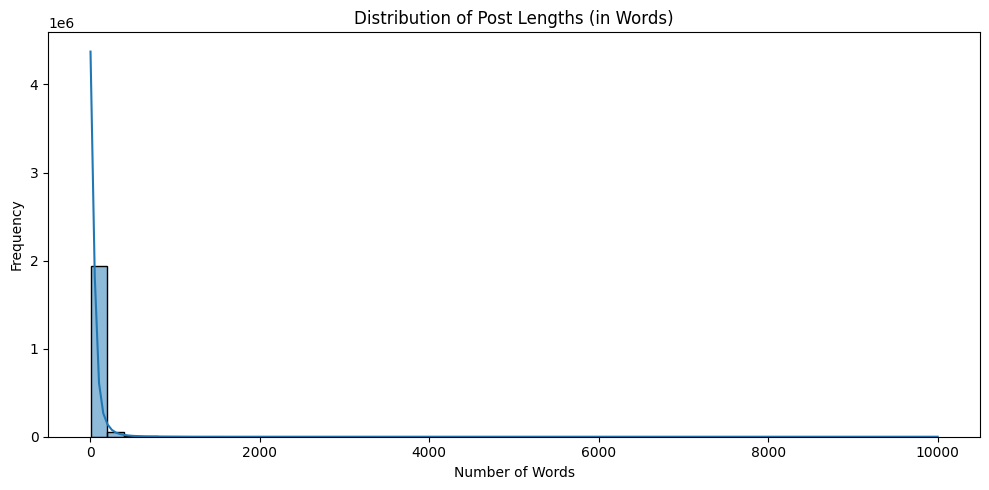

In [32]:
# Add a column to show length of each post
df_full['post_length'] = df_full['clean_text'].apply(lambda x: len(x.split()))

# Visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df_full, x='post_length', bins=50, kde=True)
plt.title("Distribution of Post Lengths (in Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


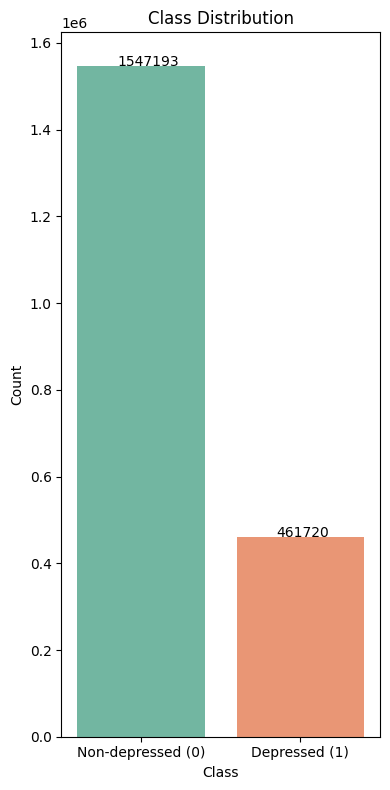

In [33]:
# Class balance
plt.figure(figsize=(4,8))
ax = sns.countplot(data=df_full, x='label', palette='Set2')
ax.set_xticklabels(['Non‑depressed (0)', 'Depressed (1)'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.25, p.get_height()+3))
plt.tight_layout()
plt.show()

In [34]:
# Quick ratio print
ratio = df_full['label'].value_counts(normalize=True).rename({0:'Non-depressed',1:'Depressed'})
print('Class ratio:\n', ratio.round(3))

Class ratio:
 label
Non-depressed    0.77
Depressed        0.23
Name: proportion, dtype: float64


In [35]:
assert 'subreddit' in df_full.columns, "Expected a 'subreddit' column in df_full."
assert 'text' in df_full.columns and 'label' in df_full.columns, "Expected 'text' and 'label' columns."

# 1) See subreddit sizes (use this to choose H)
sub_sizes = df_full['subreddit'].value_counts()
print("Top 10 subreddits by count:\n", sub_sizes.head(10), "\n")

# 2) CHOOSE THE HELD-OUT SUBREDDIT
heldout_subs = ['r/depression']

# 3) Partition into H (held-out) and T (training pool)
mask_H = df_full['subreddit'].isin(heldout_subs)
df_H = df_full[mask_H].copy()
df_T = df_full[~mask_H].copy()

print(f"Held-out subreddits (H): {heldout_subs}")
print(f"H shape: {df_H.shape}, T shape: {df_T.shape}")

# 4) Build train/val from T (stratified), leave H untouched
from sklearn.model_selection import train_test_split

X_T = df_T['text'].values
y_T = df_T['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X_T, y_T, test_size=0.20, random_state=42, stratify=y_T
)


X_shift = df_H['text'].values
y_shift = df_H['label'].values

# 6) Log distributions for transparency (paste into report if needed)
import numpy as np
def dist(y):
    vc = pd.Series(y).value_counts(normalize=True).sort_index()
    return {int(k): float(v) for k,v in vc.items()}

print("\nClass distribution (T → train):", dist(y_train))
print("Class distribution (T → val)  :", dist(y_val))
print("Class distribution (H → test) :", dist(y_shift))

# 7) Save names for the report (so you can cite them in Section 4.9)
with open('heldout_domains.txt','w',encoding='utf-8') as f:
    f.write("Held-out subreddits (H): " + ", ".join(heldout_subs) + "\n")
    f.write("Training pool excludes H (T).")


Top 10 subreddits by count:
 subreddit
teenagers       1525146
depression       282380
SuicideWatch     179340
happy             15205
DeepThoughts       6842
Name: count, dtype: int64 

Held-out subreddits (H): ['r/depression']
H shape: (0, 11), T shape: (2008913, 11)

Class distribution (T → train): {0: 0.7701642057580905, 1: 0.2298357942419095}
Class distribution (T → val)  : {0: 0.7701644917779, 1: 0.2298355082221}
Class distribution (H → test) : {}


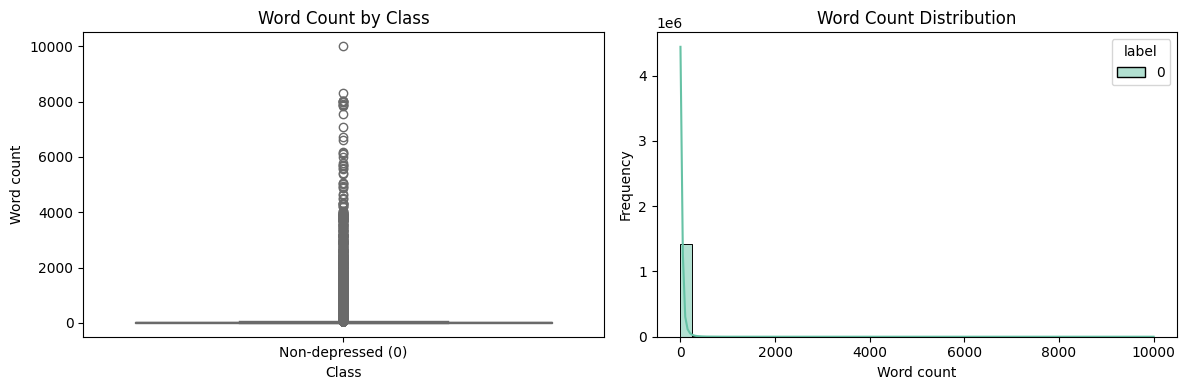

        word_len                                                char_len  \
           count   mean    std  min  25%   50%   75%      max      count   
label                                                                      
0      1437315.0  31.32  72.21  1.0  9.0  16.0  31.0  10001.0  1437315.0   

                                                        
         mean     std  min   25%   50%    75%      max  
label                                                   
0      200.07  488.02  1.0  55.0  96.0  197.0  40283.0  


In [17]:
# Basic text length features ---
df_full['char_len'] = df_full['clean_text'].str.len()
df_full['word_len'] = df_full['clean_text'].str.split().apply(len)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(data=df_full, x='label', y='word_len', palette='Set3', ax=axes[0])
axes[0].set_xticklabels(['Non‑depressed (0)', 'Depressed (1)'])
axes[0].set_title('Word Count by Class'); axes[0].set_xlabel('Class'); axes[0].set_ylabel('Word count')

sns.histplot(data=df_full, x='word_len', hue='label', bins=40, kde=True, palette='Set2', ax=axes[1])
axes[1].set_title('Word Count Distribution'); axes[1].set_xlabel('Word count'); axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(df_full[['word_len','char_len','label']].groupby('label').describe().round(2))


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_words(texts, title, top_n=25):
    vec = CountVectorizer(stop_words='english', max_features=5000)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    idx = freqs.argsort()[::-1][:top_n]
    top_words = vocab[idx]
    top_freqs = freqs[idx]

    plt.figure(figsize=(10,6))
    sns.barplot(x=top_freqs, y=top_words, orient='h', palette='viridis')
    plt.title(title); plt.xlabel('Frequency'); plt.ylabel('Word')
    plt.tight_layout(); plt.show()

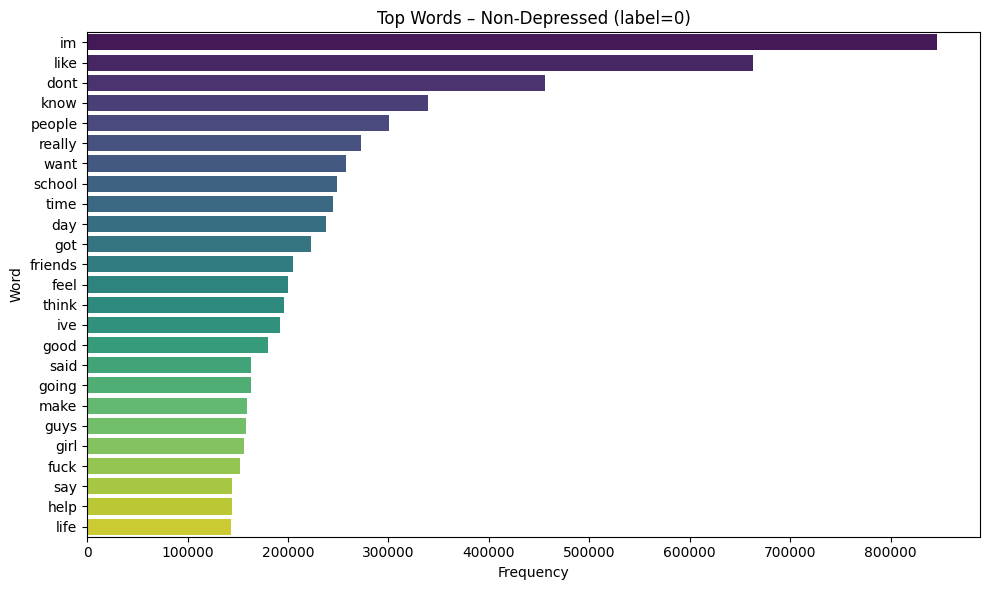

In [ ]:
# Top words by class
# plot_top_words(df_full.loc[df_full['label']==1, 'clean_text'], 'Top Words – Depressed (label=1)') # Commented out as there are no data points with label 1 in df_full
plot_top_words(df_full.loc[df_full['label']==0, 'clean_text'], 'Top Words – Non‑Depressed (label=0)')

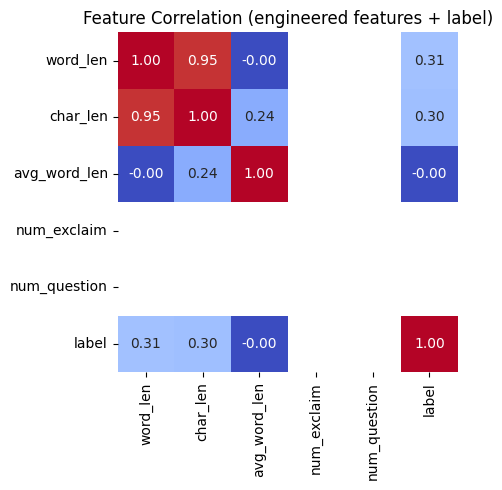

,label
label,1.000000
word_len,0.310539
char_len,0.302718
avg_word_len,-0.002556
num_exclaim,NaN
num_question,NaN


In [ ]:
# Extra lightweight features
df_full['avg_word_len'] = df_full['clean_text'].apply(
    lambda s: np.mean([len(w) for w in s.split()]) if s.split() else 0
)
df_full['num_exclaim'] = df_full['clean_text'].str.count('!')
df_full['num_question'] = df_full['clean_text'].str.count(r'\?')

corr_cols = ['word_len','char_len','avg_word_len','num_exclaim','num_question','label']
corr = df_full[corr_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=False)
plt.title('Feature Correlation (engineered features + label)')
plt.tight_layout()
plt.show()

corr['label'].sort_values(ascending=False)


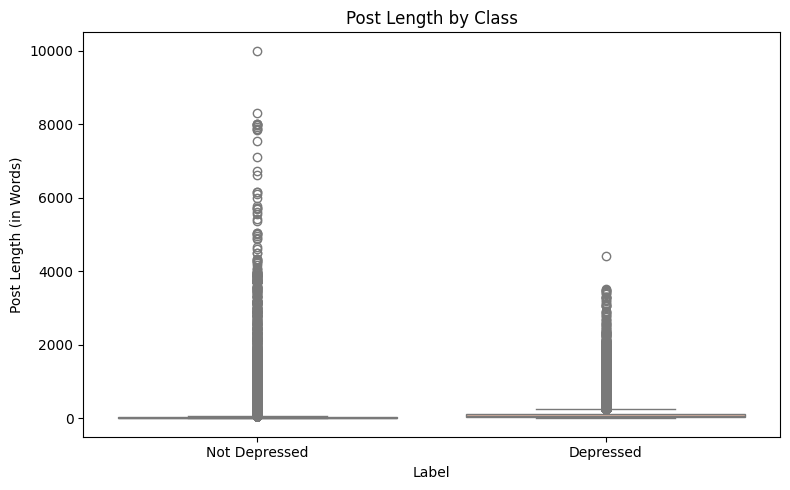

In [ ]:
# Compare how long posts are in each class
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_full, x='label', y='post_length', palette='coolwarm')
plt.xticks([0, 1], ['Not Depressed', 'Depressed'])
plt.title("Post Length by Class")
plt.xlabel("Label")
plt.ylabel("Post Length (in Words)")
plt.tight_layout()
plt.show()

In [ ]:
# Check if longer posts are more likely to be depressed
correlation = df_full[['post_length', 'label']].corr()
print("Correlation matrix:\n", correlation)


Correlation matrix:
              post_length     label
post_length     1.000000  0.310539
label           0.310539  1.000000


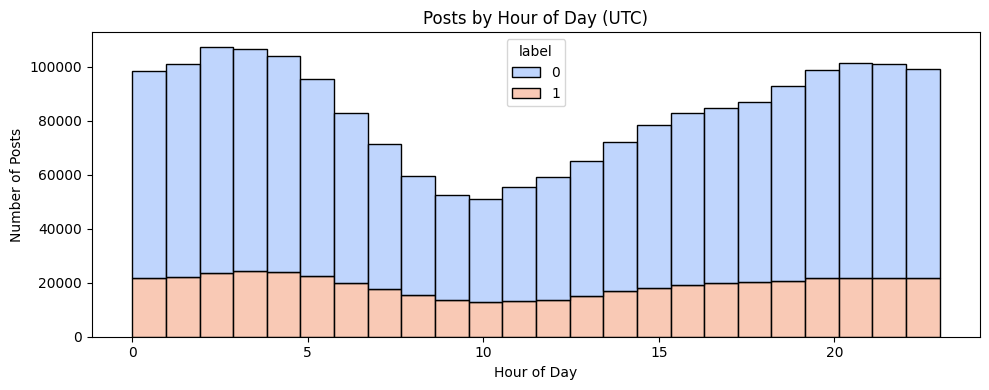

In [ ]:
# Convert timestamp and analyze time of posting
if 'created_utc' in df_full.columns:
    df_full['created_utc'] = pd.to_datetime(df_full['created_utc'], unit='s')
    df_full['hour'] = df_full['created_utc'].dt.hour

    plt.figure(figsize=(10, 4))
    sns.histplot(data=df_full, x='hour', bins=24, kde=False, hue='label', palette='coolwarm', multiple='stack')
    plt.title("Posts by Hour of Day (UTC)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Posts")
    plt.tight_layout()
    plt.show()


#Checking the Class Distribution Before Balancing

In [ ]:
label_counts = df_full['label'].value_counts()
label_ratio = df_full['label'].value_counts(normalize=True)

print("Class counts:\n", label_counts)
print("\nClass ratio:\n", label_ratio.round(3))


Class counts:
 label
0    1547193
1     461720
Name: count, dtype: int64

Class ratio:
 label
0    0.77
1    0.23
Name: proportion, dtype: float64


#Apply Balancing

In [ ]:
# Separate majority and minority classes
df_majority = df_full[df_full['label'] == 0]
df_minority = df_full[df_full['label'] == 1]

In [ ]:
# Random oversample the minority class
df_minority_oversampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

In [ ]:
# Combine back into a balanced DataFrame
df_balanced = pd.concat([df_majority, df_minority_oversampled])


In [ ]:
# Shuffle to mix classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Check new distribution
print("Balanced class counts:\n", df_balanced['label'].value_counts())

Balanced class counts:
 label
0    1547193
1    1547193
Name: count, dtype: int64


 #Train–Validation–Test Split

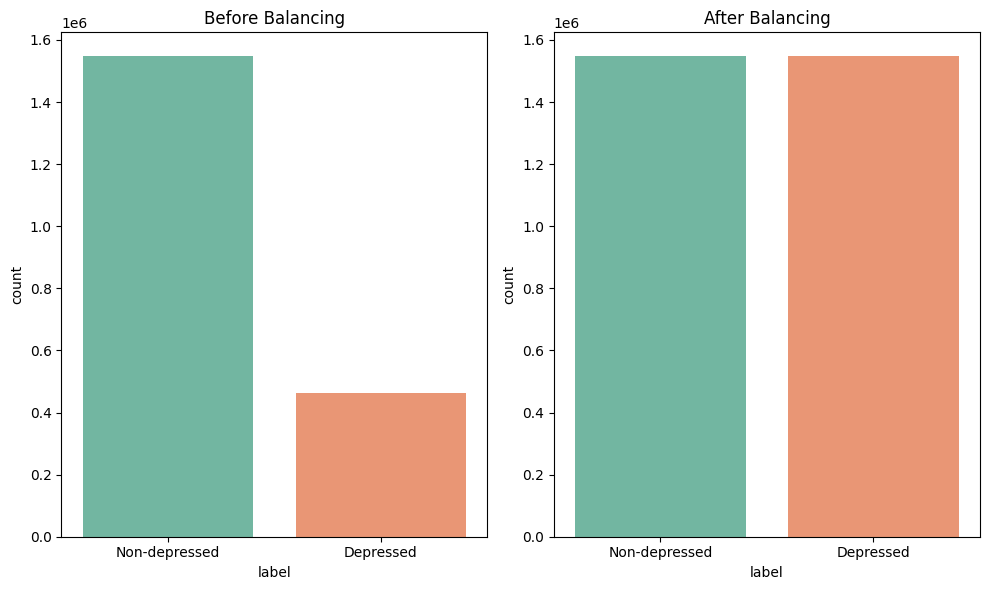

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

sns.countplot(data=df_full, x='label', palette='Set2', ax=axes[0])
axes[0].set_title("Before Balancing")
axes[0].set_xticklabels(['Non-depressed','Depressed'])

sns.countplot(data=df_balanced, x='label', palette='Set2', ax=axes[1])
axes[1].set_title("After Balancing")
axes[1].set_xticklabels(['Non-depressed','Depressed'])

plt.tight_layout()
plt.show()


In [ ]:
# Features and labels
X = df_balanced['clean_text']
y = df_balanced['label']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Further split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [ ]:
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 1980406 samples
Validation set: 495102 samples
Test set: 618878 samples


In [ ]:
print("Train distribution:\n", y_train.value_counts(normalize=True).round(3))
print("\nValidation distribution:\n", y_val.value_counts(normalize=True).round(3))
print("\nTest distribution:\n", y_test.value_counts(normalize=True).round(3))

Train distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64

Validation distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64

Test distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


# Feature Extraction – TF-IDF Vectorization


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

In [ ]:
print("TF‑IDF shapes:")
print("  train:", X_train_tfidf.shape)
print("  valid:", X_valid_tfidf.shape)
print("  test :", X_test_tfidf.shape)


TF‑IDF shapes:
  train: (1980406, 10000)
  valid: (495102, 10000)
  test : (618878, 10000)


In [ ]:
# split using X_val / y_val, alias them to X_valid / y_valid
if 'X_val' in globals() and 'y_val' in globals():
    X_valid = X_val
    y_valid = y_val

# split using X_valid / y_valid, alias them to X_val / y_val (optional)
if 'X_valid' in globals() and 'y_valid' in globals():
    X_val = X_valid
    y_val = y_valid

# Sanity checks
for name in ['X_train','y_train','X_valid','y_valid','X_val','y_val','X_test','y_test']:
    if name not in globals():
        print(f"Missing variable: {name}")

# Hard stop if the essentials are missing
assert 'X_train' in globals() and 'y_train' in globals(), "X_train / y_train not found."
assert 'X_valid' in globals() and 'y_valid' in globals(), "Validation split not found. Use X_valid / y_valid or X_val / y_val."
assert 'X_test'  in globals() and 'y_test'  in globals(), "X_test / y_test not found."
print("Split variables are normalized (X_train/X_valid/X_test; y_train/y_valid/y_test).")


Split variables are normalized (X_train/X_valid/X_test; y_train/y_valid/y_test).


In [ ]:
plt.rcParams["figure.dpi"] = 140

def summarize_metrics(y_true, y_pred, scores_for_auc=None):
    """
    scores_for_auc: use probabilities (preferred) or decision scores for ROC/PR AUC
    """
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)
    out = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    if scores_for_auc is not None:
        out["roc_auc"] = roc_auc_score(y_true, scores_for_auc)
        out["pr_auc"]  = average_precision_score(y_true, scores_for_auc)
    return out

def plot_confmat(y_true, y_pred, title, cmap="Blues"):
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                           display_labels=["Non-Depressed (0)", "Depressed (1)"]).plot(cmap=cmap)
    plt.title(title); plt.tight_layout(); plt.show()

def plot_roc_pr(y_true, scores, title_prefix):
    fpr, tpr, _ = roc_curve(y_true, scores)
    prec, rec, _ = precision_recall_curve(y_true, scores)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, scores):.3f}")
    plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{title_prefix} – ROC"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f"AP={average_precision_score(y_true, scores):.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title_prefix} – Precision–Recall"); plt.legend(); plt.tight_layout(); plt.show()


# Baseline Model 1: Logistic Regression Model

In [ ]:
# Train
lr = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced',
    solver='liblinear', max_iter=2000
)
lr.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, solver='liblinear')

In [ ]:
# Validate & Test
val_proba_lr = lr.predict_proba(X_valid_tfidf)[:, 1]
val_pred_lr  = (val_proba_lr >= 0.5).astype(int)

test_proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]
test_pred_lr  = (test_proba_lr >= 0.5).astype(int)

In [ ]:
print("=== Logistic Regression — Validation ===")
print(classification_report(y_val, val_pred_lr, target_names=["Non‑Depressed","Depressed"]))
print("ROC‑AUC (val):", roc_auc_score(y_val, val_proba_lr))


=== Logistic Regression — Validation ===
               precision    recall  f1-score   support

Non‑Depressed       0.92      0.93      0.93    247551
    Depressed       0.93      0.92      0.93    247551

     accuracy                           0.93    495102
    macro avg       0.93      0.93      0.93    495102
 weighted avg       0.93      0.93      0.93    495102

ROC‑AUC (val): 0.9777807541378072


In [ ]:
print("\n=== Logistic Regression — Test ===")
print(classification_report(y_test, test_pred_lr, target_names=["Non‑Depressed","Depressed"]))
print("ROC‑AUC (test):", roc_auc_score(y_test, test_proba_lr))



=== Logistic Regression — Test ===
               precision    recall  f1-score   support

Non‑Depressed       0.92      0.93      0.93    309439
    Depressed       0.93      0.92      0.93    309439

     accuracy                           0.93    618878
    macro avg       0.93      0.93      0.93    618878
 weighted avg       0.93      0.93      0.93    618878

ROC‑AUC (test): 0.9777572683332615


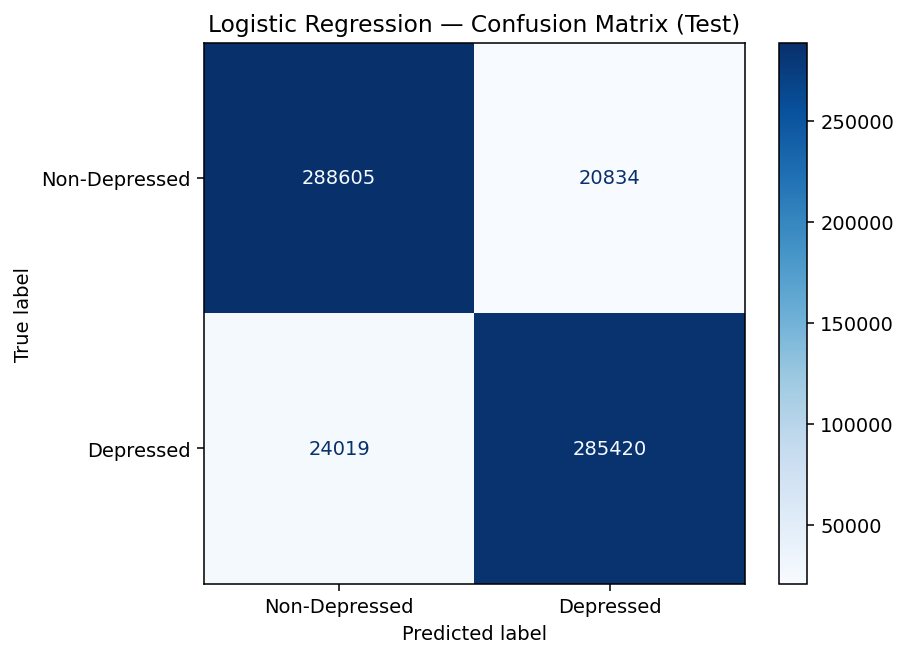

In [ ]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, test_pred_lr, display_labels=["Non‑Depressed","Depressed"],
    cmap="Blues", values_format="d"
)
plt.title("Logistic Regression — Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

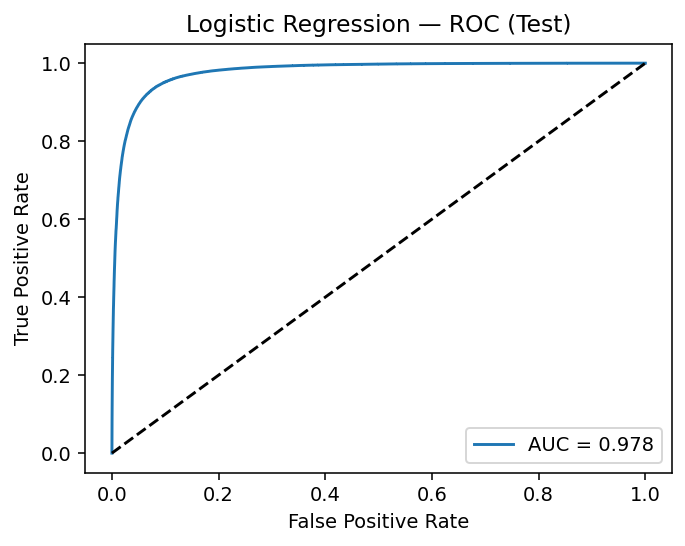

In [ ]:
# ROC
fpr, tpr, _ = roc_curve(y_test, test_proba_lr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, test_proba_lr):.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Logistic Regression — ROC (Test)"); plt.legend(); plt.tight_layout(); plt.show()


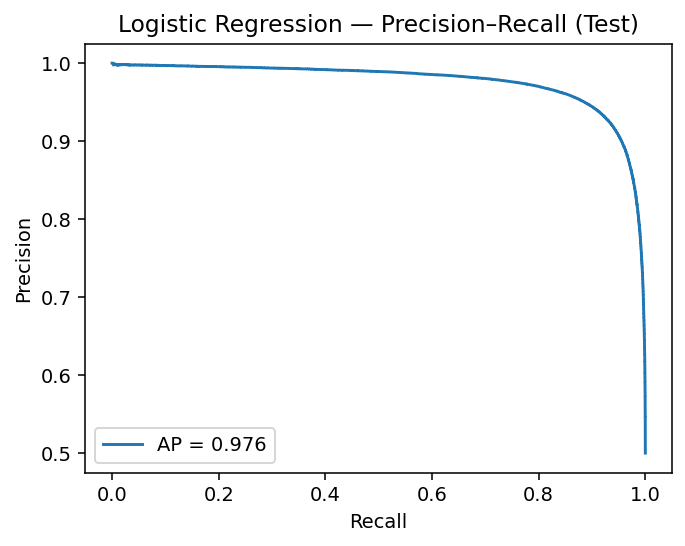

In [ ]:
# Precision–Recall
prec, rec, _ = precision_recall_curve(y_test, test_proba_lr)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, test_proba_lr):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Logistic Regression — Precision–Recall (Test)"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
feature_names = tfidf.get_feature_names_out()
coefs = lr.coef_[0]

top_pos_idx = np.argsort(coefs)[-20:]
top_neg_idx = np.argsort(coefs)[:20]


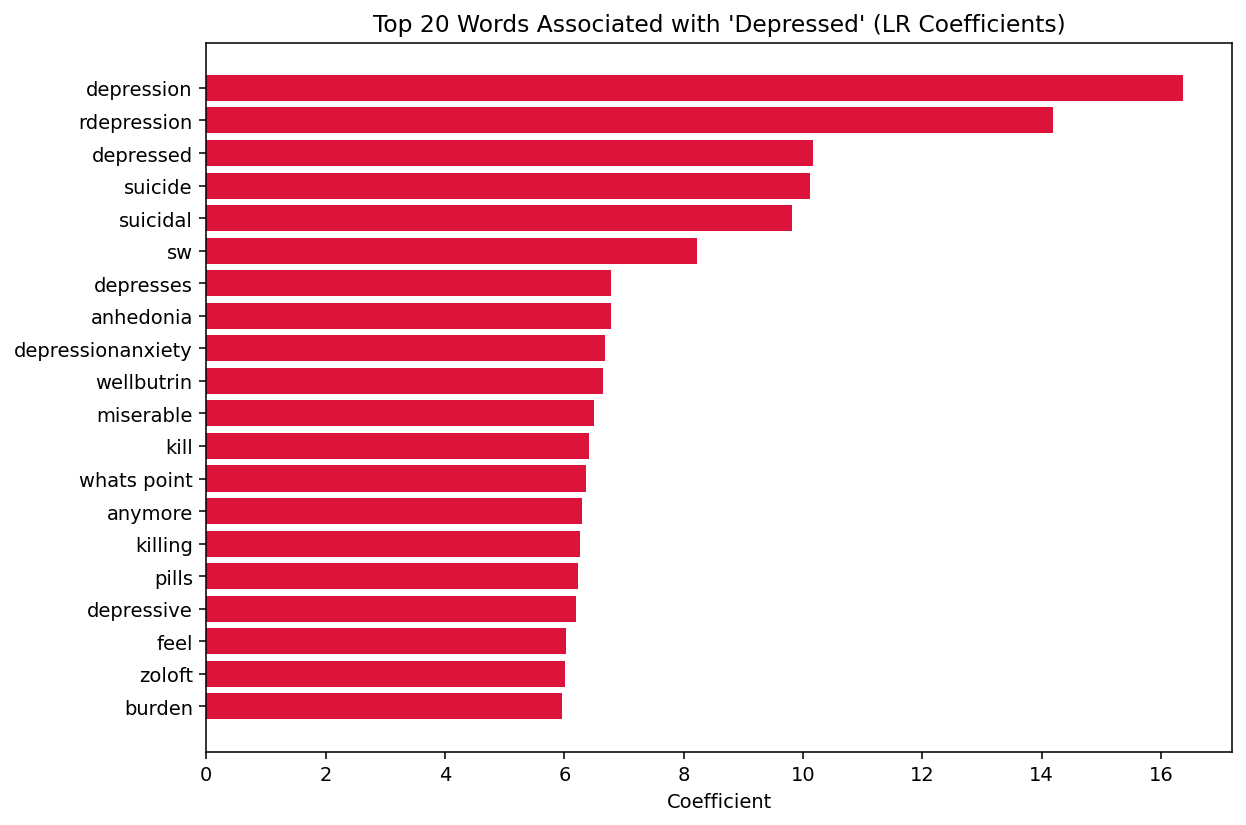

In [ ]:
plt.figure(figsize=(9,6))
plt.barh(range(20), coefs[top_pos_idx], color='crimson')
plt.yticks(range(20), feature_names[top_pos_idx])
plt.title("Top 20 Words Associated with 'Depressed' (LR Coefficients)")
plt.xlabel("Coefficient"); plt.tight_layout(); plt.show()


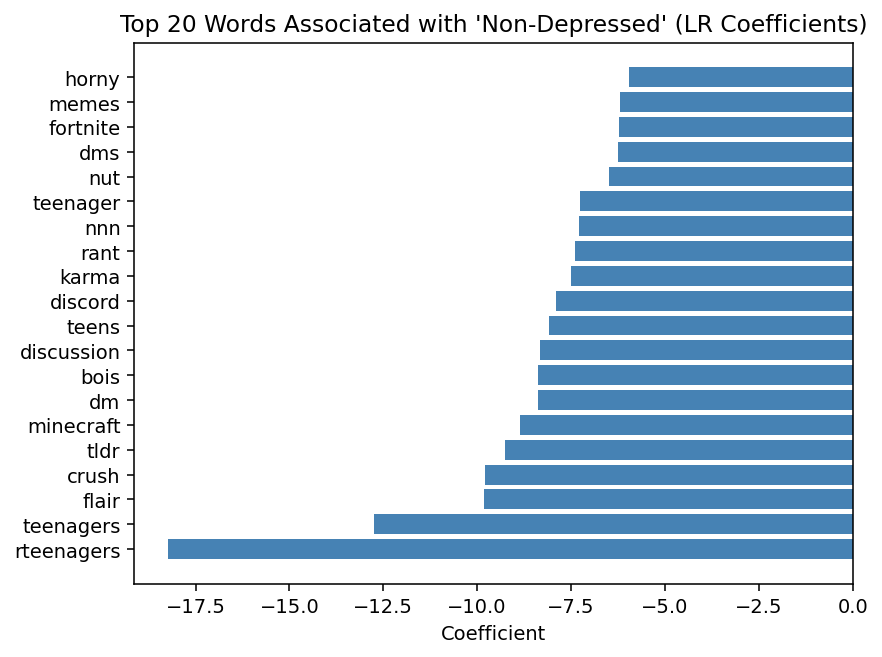

In [ ]:


plt.barh(range(20), coefs[top_neg_idx], color='steelblue')
plt.yticks(range(20), feature_names[top_neg_idx])
plt.title("Top 20 Words Associated with 'Non‑Depressed' (LR Coefficients)")
plt.xlabel("Coefficient"); plt.tight_layout(); plt.show()


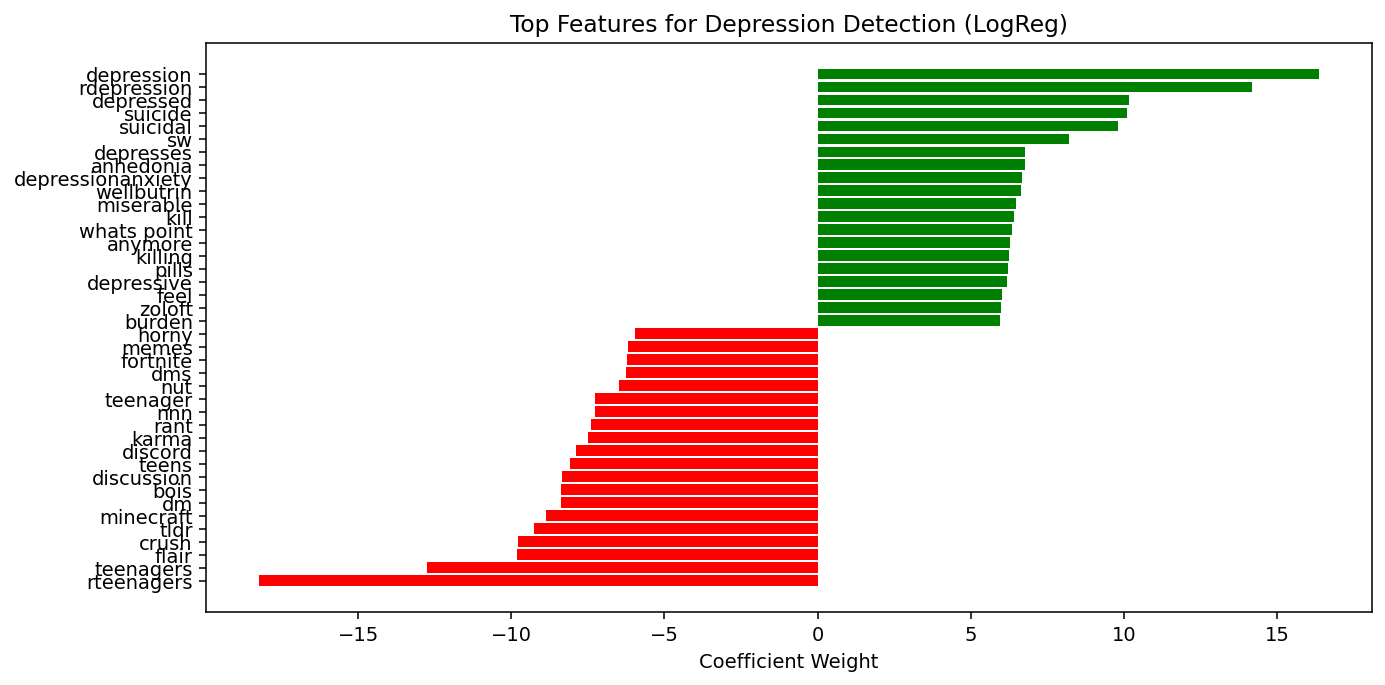

In [ ]:
# Feature importance for Logistic Regression (TF-IDF coefficients)
feature_names = np.array(tfidf.get_feature_names_out())
coefs = lr.coef_[0]

top_pos_idx = np.argsort(coefs)[-20:]
top_neg_idx = np.argsort(coefs)[:20]

plt.figure(figsize=(10,5))
plt.barh(feature_names[top_neg_idx], coefs[top_neg_idx], color="red")
plt.barh(feature_names[top_pos_idx], coefs[top_pos_idx], color="green")
plt.title("Top Features for Depression Detection (LogReg)")
plt.xlabel("Coefficient Weight")
plt.tight_layout(); plt.show()


# Applying the SHAP for LR¶


In [ ]:
# Alias validation names so SHAP code "just works"
if 'X_valid' in globals() and 'y_valid' in globals():
    X_val = X_valid
    y_val = y_valid
assert 'X_val' in globals() and 'y_val' in globals(), "Need X_val / y_val in scope."


In [ ]:
!pip install --quiet shap
import shap

In [ ]:
# Reusing the trained objects
feature_names = tfidf.get_feature_names_out()
coefs = lr.coef_[0]

In [ ]:
# Limit to top |coef| features for speed/memory
top_k = 1000
top_idx = np.argsort(np.abs(coefs))[-top_k:]
feat_top = feature_names[top_idx]

In [ ]:
X_train_top = X_train_tfidf[:, top_idx]
X_val_top   = X_valid_tfidf[:,   top_idx]

In [ ]:
# Small background (200) and validation sample (200) -> SHAP is much faster
bg     = X_train_top[:200].toarray()
sample = X_val_top[:200].toarray()

In [ ]:
# LinearExplainer is ideal for linear models like LR on TF-IDF
explainer_lr = shap.LinearExplainer(lr, X_train_tfidf[:200].toarray())
shap_values  = explainer_lr(X_valid_tfidf[:200].toarray())

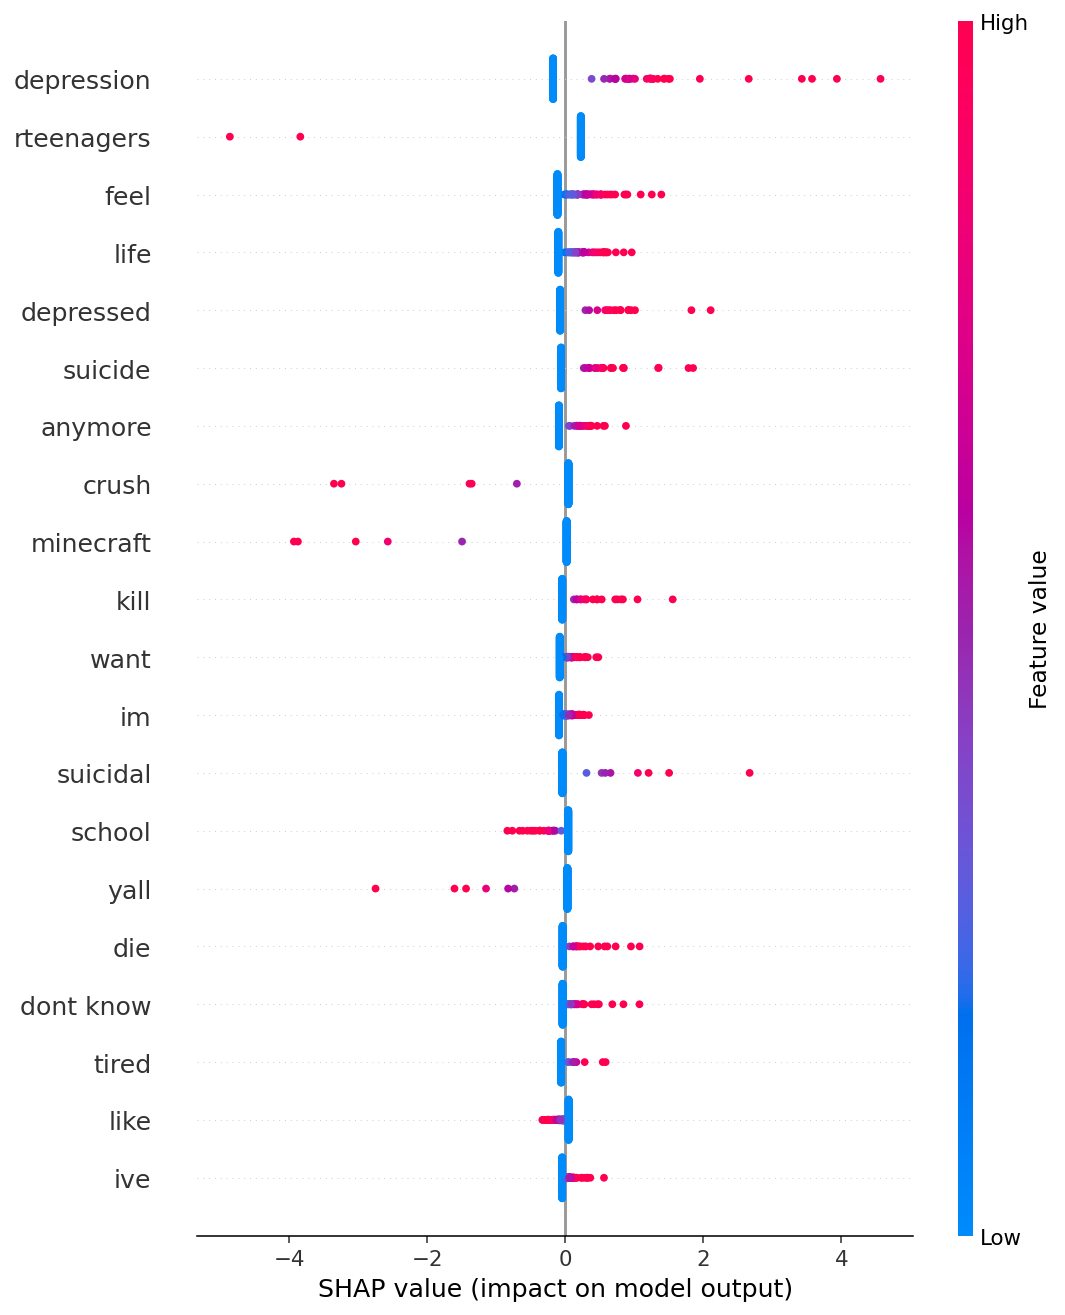

In [ ]:
# Global summary: which features matter overall
shap.summary_plot(shap_values, X_valid_tfidf[:200].toarray(), feature_names=feature_names, show=True)  # beeswarm

In [ ]:
# Local explanation for one example
i = 0
print("LR predicted P(Depressed) for example", i, ":", lr.predict_proba(X_valid_tfidf[i])[0,1])


LR predicted P(Depressed) for example 0 : 0.00010155858276299146


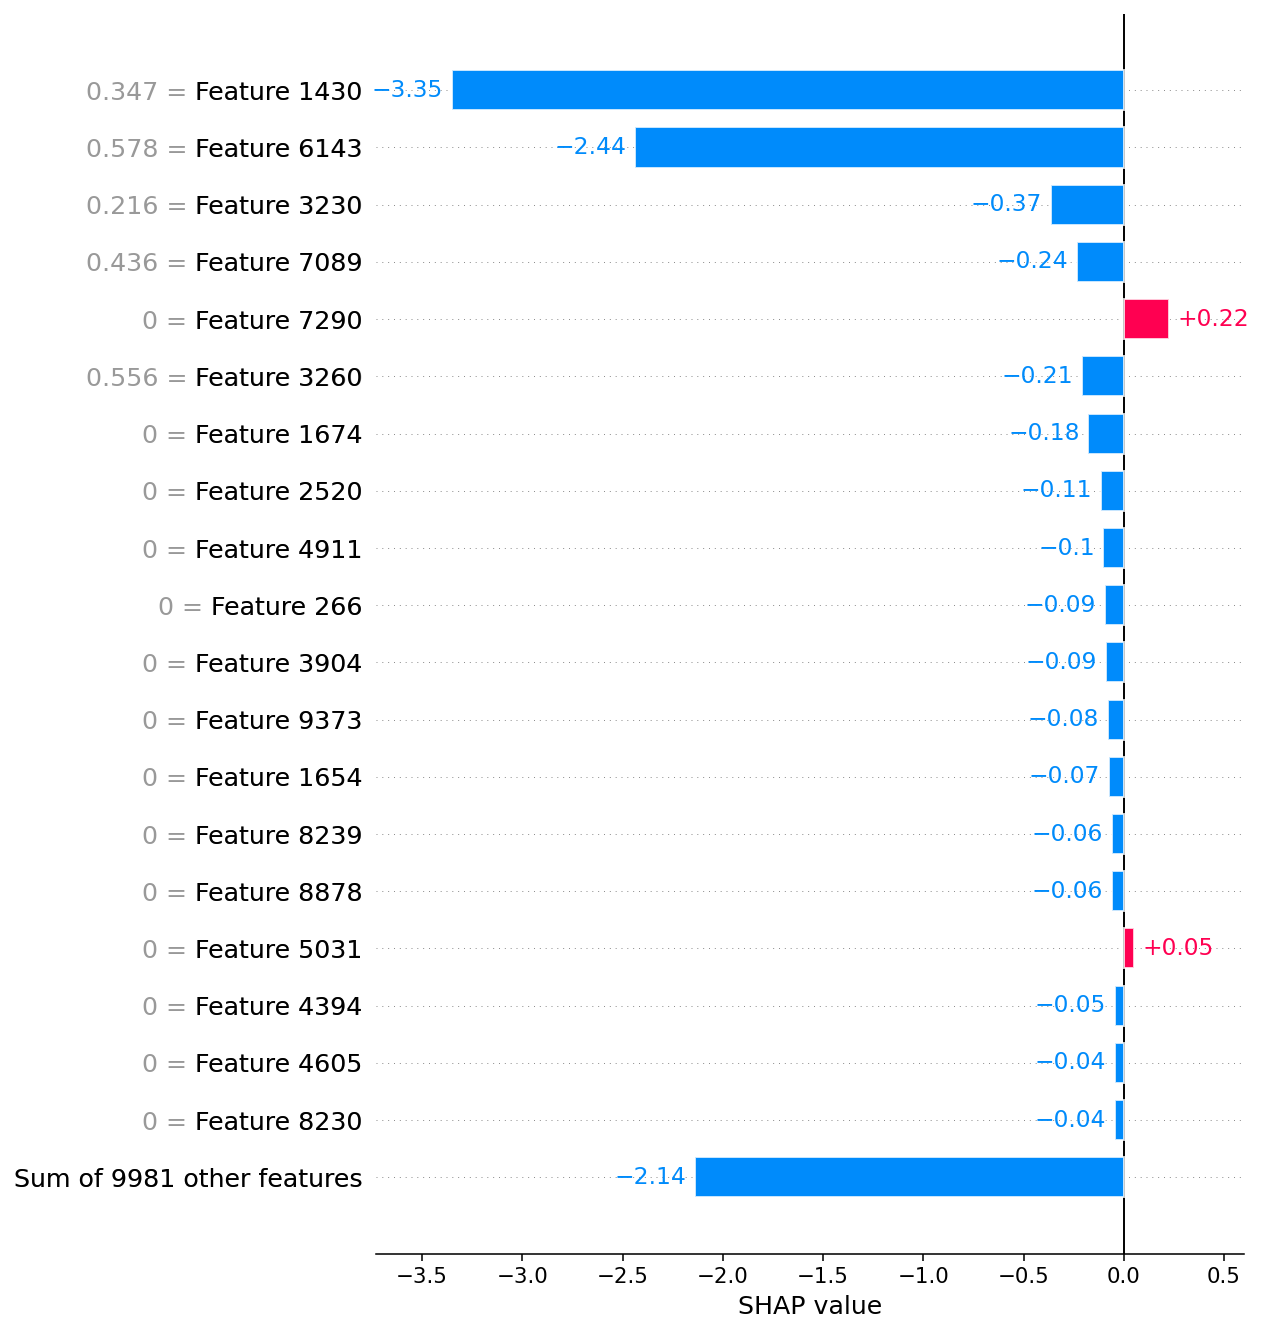

In [ ]:
# Bar plot of top positive/negative contributors for that example
shap.plots.bar(shap_values[i], max_display=20, show=True)

# Baseline Model 2: Linear SVM

In [ ]:
# Model Train
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

LinearSVC()

In [ ]:
# decision_function gives continuous margin scores
val_scores_svm = svm.decision_function(X_valid_tfidf)
val_pred_svm   = (val_scores_svm >= 0).astype(int)

test_scores_svm = svm.decision_function(X_test_tfidf)
test_pred_svm   = (test_scores_svm >= 0).astype(int)

In [ ]:
print("Linear SVM — Validation")
print(classification_report(y_val, val_pred_svm, target_names=["Non‑Depressed","Depressed"]))
print("ROC‑AUC (val):", roc_auc_score(y_val, val_scores_svm))


Linear SVM — Validation
               precision    recall  f1-score   support

Non‑Depressed       0.92      0.93      0.93    247551
    Depressed       0.93      0.92      0.93    247551

     accuracy                           0.93    495102
    macro avg       0.93      0.93      0.93    495102
 weighted avg       0.93      0.93      0.93    495102

ROC‑AUC (val): 0.9778119572590568


In [ ]:
print("\nLinear SVM - Test")
print(classification_report(y_test, test_pred_svm, target_names=["Non‑Depressed","Depressed"]))
print("ROC‑AUC (test):", roc_auc_score(y_test, test_scores_svm))



Linear SVM - Test
               precision    recall  f1-score   support

Non‑Depressed       0.92      0.93      0.93    309439
    Depressed       0.93      0.92      0.93    309439

     accuracy                           0.93    618878
    macro avg       0.93      0.93      0.93    618878
 weighted avg       0.93      0.93      0.93    618878

ROC‑AUC (test): 0.9778082367024326


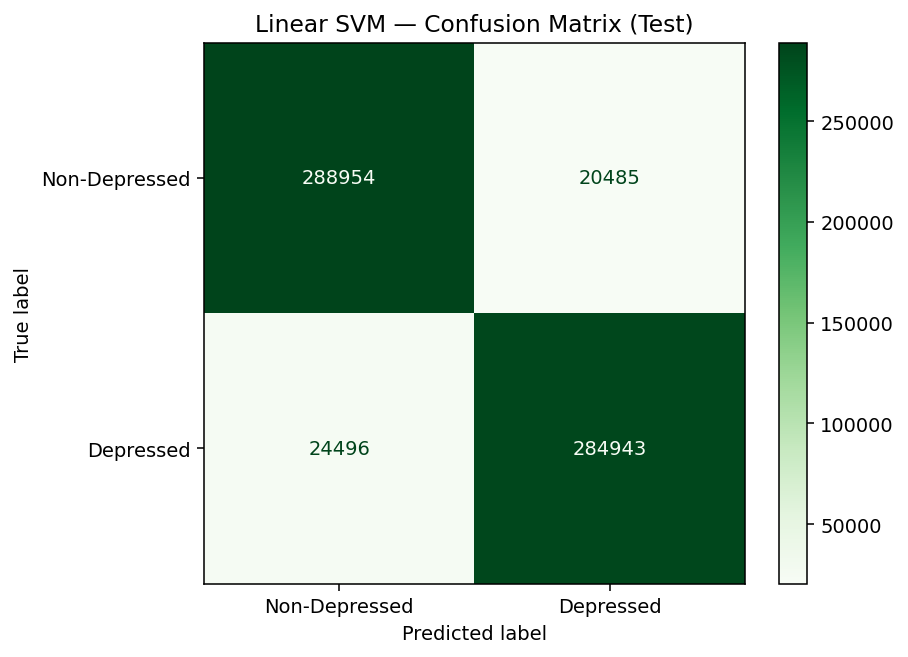

In [ ]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, test_pred_svm, display_labels=["Non‑Depressed","Depressed"],
    cmap="Greens", values_format="d"
)
plt.title("Linear SVM — Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

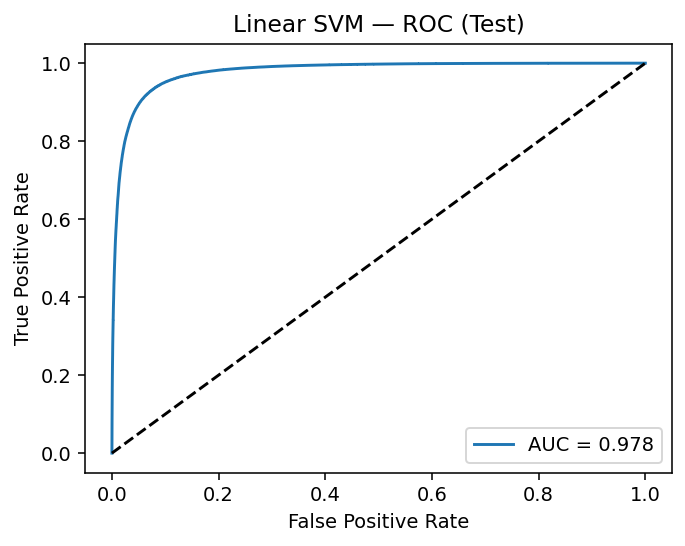

In [ ]:
# ROC
fpr, tpr, _ = roc_curve(y_test, test_scores_svm)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, test_scores_svm):.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Linear SVM — ROC (Test)"); plt.legend(); plt.tight_layout(); plt.show()


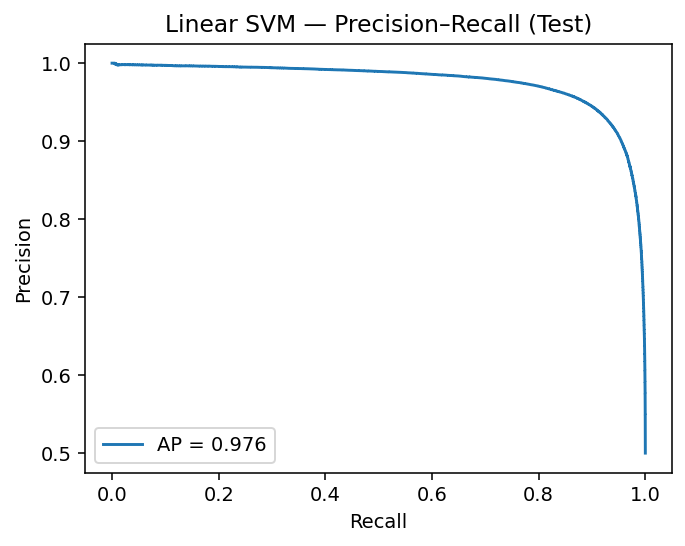

In [ ]:
# Precision–Recall (Test)
prec, rec, _ = precision_recall_curve(y_test, test_scores_svm)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, test_scores_svm):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Linear SVM — Precision–Recall (Test)"); plt.legend(); plt.tight_layout(); plt.show()


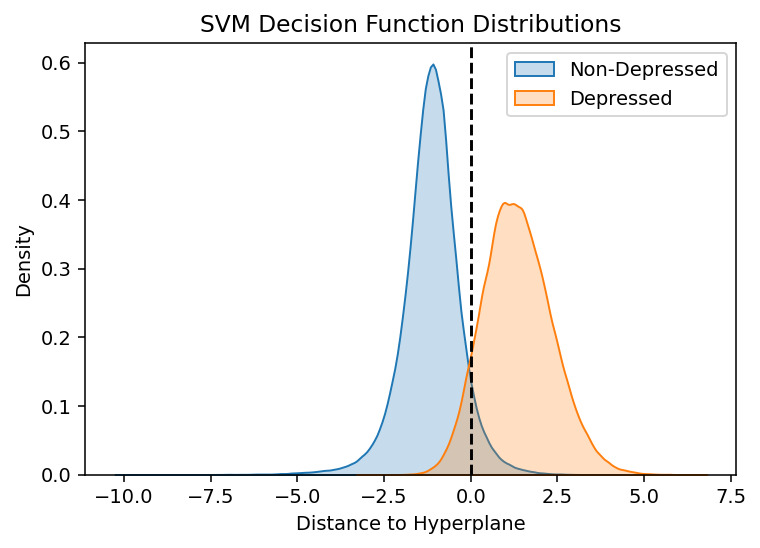

In [ ]:
# Distance to decision boundary
decision_values = svm.decision_function(X_test_tfidf)

plt.figure(figsize=(6,4))
sns.kdeplot(decision_values[y_test==0], label="Non-Depressed", shade=True)
sns.kdeplot(decision_values[y_test==1], label="Depressed", shade=True)
plt.axvline(0, color="black", linestyle="--")
plt.title("SVM Decision Function Distributions")
plt.xlabel("Distance to Hyperplane")
plt.legend(); plt.show()


### LR and SVM comparison table

In [ ]:
# Build rows only for models you've trained
rows_val = []
rows_test = []

In [ ]:
# Logistic Regression
rows_val.append({"Model":"LogReg", "F1": f1_score(y_val, (val_proba_lr>=0.5)),
                 "ROC_AUC": roc_auc_score(y_val, val_proba_lr),
                 "PR_AUC": average_precision_score(y_val, val_proba_lr)})
rows_test.append({"Model":"LogReg", "F1": f1_score(y_test, (test_proba_lr>=0.5)),
                  "ROC_AUC": roc_auc_score(y_test, test_proba_lr),
                  "PR_AUC": average_precision_score(y_test, test_proba_lr)})


In [ ]:
# Linear SVM (uses decision scores, not probabilities)
rows_val.append({"Model":"LinearSVM", "F1": f1_score(y_val, (val_scores_svm>=0)),
                 "ROC_AUC": roc_auc_score(y_val, val_scores_svm),
                 "PR_AUC": average_precision_score(y_val, val_scores_svm)})
rows_test.append({"Model":"LinearSVM", "F1": f1_score(y_test, (test_scores_svm>=0)),
                  "ROC_AUC": roc_auc_score(y_test, test_scores_svm),
                  "PR_AUC": average_precision_score(y_test, test_scores_svm)})


In [ ]:
cmp_val  = pd.DataFrame(rows_val).sort_values("F1", ascending=False).round(4)
cmp_test = pd.DataFrame(rows_test).sort_values("F1", ascending=False).round(4)

In [ ]:
print("VALIDATION"); display(cmp_val)
print("TEST"); display(cmp_test)


VALIDATION


,Model,F1,ROC_AUC,PR_AUC
0,LogReg,0.9273,0.9778,0.9759
1,LinearSVM,0.9270,0.9778,0.9761


TEST


,Model,F1,ROC_AUC,PR_AUC
0,LogReg,0.9272,0.9778,0.9758
1,LinearSVM,0.9268,0.9778,0.9760


### Threshold tuning (optimize F1 or target recall)

In [ ]:
def find_best_threshold(y_true, scores, metric="f1", min_recall=None):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    thr = np.append(thr, 1.0)  # align lengths
    if metric == "f1":
        f1s = 2*(prec*rec)/(prec+rec+1e-12)
        if min_recall is not None:
            f1s[rec < min_recall] = -1
        idx = np.argmax(f1s)
        return thr[idx], {"precision":prec[idx], "recall":rec[idx], "f1":f1s[idx]}
    else:
        raise ValueError("metric not supported")

In [ ]:
# Example: tune LR on validation scores to max F1 (or ensure recall≥0.85)
best_thr_lr, stats_lr = find_best_threshold(y_val, val_proba_lr, metric="f1", min_recall=None)
print("Best LR threshold:", round(best_thr_lr,3), stats_lr)


Best LR threshold: 0.419 {'precision': np.float64(0.9186955920961725), 'recall': np.float64(0.9400123610892301), 'f1': np.float64(0.9292317398955959)}


In [ ]:
# Apply tuned threshold to test set
test_pred_lr_tuned = (test_proba_lr >= best_thr_lr).astype(int)
from sklearn.metrics import classification_report
print("\nLR (Test) with tuned threshold:")
print(classification_report(y_test, test_pred_lr_tuned, target_names=["Non-Depressed","Depressed"]))



LR (Test) with tuned threshold:
               precision    recall  f1-score   support

Non-Depressed       0.94      0.92      0.93    309439
    Depressed       0.92      0.94      0.93    309439

     accuracy                           0.93    618878
    macro avg       0.93      0.93      0.93    618878
 weighted avg       0.93      0.93      0.93    618878



## Probability calibration + calibration plot (LR)

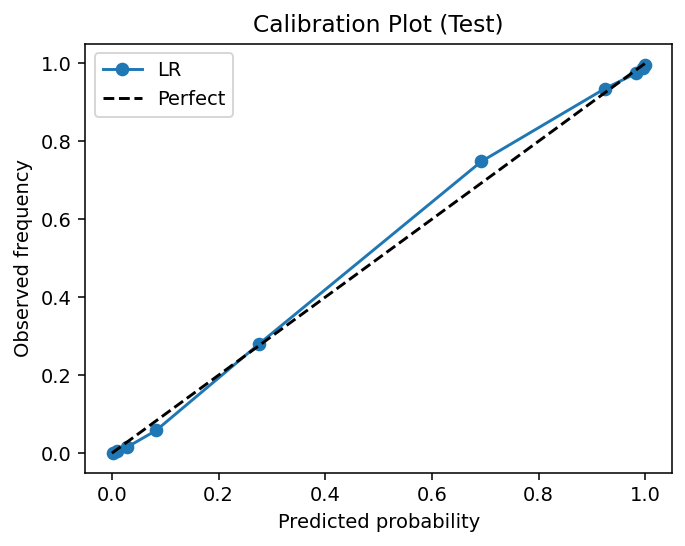

In [ ]:
# LR is already probabilistic, but let's visualize calibration
prob_true, prob_pred = calibration_curve(y_test, test_proba_lr, n_bins=10, strategy='quantile')

plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker='o', label='LR')
plt.plot([0,1],[0,1],'k--', label='Perfect')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Calibration Plot (Test)')
plt.legend(); plt.tight_layout(); plt.show()


### Error analysis:- By showing few examples of FP/FN

In [ ]:
test_pred_lr = (test_proba_lr >= 0.5).astype(int)

errors = pd.DataFrame({
    "text": X_test.reset_index(drop=True),
    "y_true": y_test.reset_index(drop=True),
    "y_pred": test_pred_lr,
    "p_depressed": test_proba_lr
})

false_pos = errors[(errors.y_true==0) & (errors.y_pred==1)].sort_values("p_depressed", ascending=False).head(10)
false_neg = errors[(errors.y_true==1) & (errors.y_pred==0)].sort_values("p_depressed").head(10)

In [ ]:
print("Top 5 False Positives:"); display(false_pos.head(5)[["p_depressed","text"]])

Top 5 False Positives:


,p_depressed,text
67185,0.999999,depression
266686,0.999999,depression
565354,0.999997,didnt think would live see th birthday guess i...
472323,0.999996,truth depression everyone one point another ex...
76065,0.999996,ive dealt depression whole life ive recently l...


In [ ]:
print("Top 5 False Negatives:"); display(false_neg.head(5)[["p_depressed","text"]])


Top 5 False Negatives:


,p_depressed,text
350446,0.000057,anyone dm please need someone
141464,0.000079,found report missused awards wholesome awards ...
182243,0.000103,crush friend started dating crush feel alone d...
171387,0.000130,come life unfair kids beat last monday reason ...
35440,0.000266,crushes crush crush girl keeps sending message...


### Quick hyperparameter search

In [ ]:
# Logistic Regression C search
grid_lr = GridSearchCV(
    LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=2000),
    param_grid={"C":[0.25, 0.5, 1.0, 2.0, 4.0]},
    scoring="f1",
    cv=3,
    n_jobs=-1
)
grid_lr.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.25, 0.5, 1.0, 2.0, 4.0]},
             scoring='f1')

In [ ]:
print("Best LR params:", grid_lr.best_params_, "Best CV F1:", grid_lr.best_score_)

Best LR params: {'C': 2.0} Best CV F1: 0.9271576653362913


In [ ]:
# SVM C search
from sklearn.svm import LinearSVC
grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid={"C":[0.25, 0.5, 1.0, 2.0, 4.0]},
    scoring="f1",
    cv=3,
    n_jobs=-1
)
grid_svm.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 1.0, 2.0, 4.0]}, scoring='f1')

In [ ]:
print("Best SVM params:", grid_svm.best_params_, "Best CV F1:", grid_svm.best_score_)

Best SVM params: {'C': 0.5} Best CV F1: 0.9266293797489613


# BiLSTM MODEL (Deep Learning Approach)
##### Using tokenized Reddit posts + optional GloVe embeddings


In [ ]:
!pip install --quiet tensorflow

Setup & sanity checks

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), "Missing X_* splits"
assert 'y_train' in globals() and 'y_val' in globals() and 'y_test' in globals(), "Missing y_* splits"

# Keepping reproducible
tf.random.set_seed(42)
np.random.seed(42)

print(f"Samples: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")


Samples: train=1980406, val=495102, test=618878


Tokenize & pad sequences

In [ ]:
# Hyperparams
MAX_VOCAB   = 30000
MAX_LEN     = 200
OOV_TOKEN   = "<OOV>"

In [ ]:
# Fitting tokenizer on training text
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

In [ ]:
# Converting to integer sequences
def to_seq(texts):
    return tokenizer.texts_to_sequences(texts)

Xtr_seq = to_seq(X_train)
Xva_seq = to_seq(X_val)
Xte_seq = to_seq(X_test)


In [ ]:
# Pad to fixed length
Xtr_pad = pad_sequences(Xtr_seq, maxlen=MAX_LEN, padding='post', truncating='post')
Xva_pad = pad_sequences(Xva_seq, maxlen=MAX_LEN, padding='post', truncating='post')
Xte_pad = pad_sequences(Xte_seq, maxlen=MAX_LEN, padding='post', truncating='post')

ytr = np.asarray(y_train).astype(int)
yva = np.asarray(y_val).astype(int)
yte = np.asarray(y_test).astype(int)

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

In [ ]:
print("Vocab size used:", vocab_size, "| Sequence shape:", Xtr_pad.shape)

Vocab size used: 30000 | Sequence shape: (1980406, 200)


In [ ]:
import os, zipfile, io, requests


In [ ]:
EMB_DIM = 100
MAX_VOCAB   = 30000
OOV_TOKEN   = "<OOV>"

glove_zip_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_dir = "glove"
glove_zip = os.path.join(glove_dir, "glove.6B.zip")
glove_txt = os.path.join(glove_dir, f"glove.6B.{EMB_DIM}d.txt")

os.makedirs(glove_dir, exist_ok=True)

def ensure_glove():
    if not os.path.exists(glove_txt):
        try:
            print("Downloading GloVe embeddings...")
            r = requests.get(glove_zip_url, timeout=60)
            z = zipfile.ZipFile(io.BytesIO(r.content))
            z.extractall(glove_dir)
            print("GloVe downloaded and extracted.")
        except Exception as e:
            print("Could not download GloVe:", e)

ensure_glove()

GloVe downloaded and extracted.


In [ ]:
# Fitting tokenizer on training text
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)


In [ ]:
# Build embedding matrix
embedding_matrix = np.random.normal(0, 0.6, size=(vocab_size, EMB_DIM)).astype(np.float32)
found = 0

if os.path.exists(glove_txt):
    print("Loading embeddings from:", glove_txt)
    embeddings_index = {}
    with open(glove_txt, encoding="utf-8") as f:
        for line in f:
            values = line.rstrip().split(" ")
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    for word, idx in tokenizer.word_index.items():
        if idx >= vocab_size:
            continue
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
            found += 1
    print(f"Loaded {found} / {vocab_size} embeddings.")
else:
    print("GloVe not available; using random trainable embeddings.")

Loading embeddings from: glove/glove.6B.100d.txt
Loaded 26996 / 30000 embeddings.


### Building the BiLSTM model

In [ ]:
def build_bilstm(vocab_size, emb_dim=EMB_DIM, max_len=MAX_LEN, use_pretrained=True):
    inp = layers.Input(shape=(max_len,), dtype="int32")

    if use_pretrained and os.path.exists(glove_txt):
        emb = layers.Embedding(
            input_dim=vocab_size, output_dim=emb_dim,
            weights=[embedding_matrix], input_length=max_len,
            trainable=False, name="embeddings"
        )(inp)
    else:
        emb = layers.Embedding(
            input_dim=vocab_size, output_dim=emb_dim,
            input_length=max_len, name="embeddings"
        )(inp)

    x = layers.SpatialDropout1D(0.2)(emb)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inp, out)
    opt = optimizers.Adam(learning_rate=2e-3)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
bilstm = build_bilstm(vocab_size, EMB_DIM, MAX_LEN, use_pretrained=True)
bilstm.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings (Embedding)          │ (None, 200, 100)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,251,009 (12.40 MB)

 Trainable params: 251,009 (980.50 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:
# Computing class weights from the training labels
classes = np.unique(ytr)
class_wts = compute_class_weight(class_weight="balanced", classes=classes, y=ytr)
class_wts = {int(c): w for c, w in zip(classes, class_wts)}

In [ ]:
print("Class weights:", class_wts)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
# Early stopping + best model checkpoint
ckpt_path = "bilstm_best.h5"
cbs = [
    callbacks.EarlyStopping(monitor="val_f1", mode="max", patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_f1", mode="max", save_best_only=True, verbose=1)
]

In [ ]:
# Custom F1 metric
def f1_m(y_true, y_pred, thresh=0.5):
    y_pred = tf.cast(y_pred > thresh, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true*y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1-y_true)*y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true*(1-y_pred), tf.float32))
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    return 2*precision*recall/(precision+recall+1e-12)

bilstm.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=2e-3),
    metrics=["accuracy", f1_m]
)

history = bilstm.fit(
    Xtr_pad, ytr,
    validation_data=(Xva_pad, yva),
    epochs=8,
    batch_size=128,
    class_weight=class_wts,
    callbacks=cbs,
    verbose=1
)

Epoch 1/8
15471/15472 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9062 - f1_m: 0.5027 - loss: 0.2393

15472/15472 ━━━━━━━━━━━━━━━━━━━━ 319s 20ms/step - accuracy: 0.9062 - f1_m: 0.5027 - loss: 0.2393 - val_accuracy: 0.9329 - val_f1_m: 0.5099 - val_loss: 0.1747
Epoch 2/8
15470/15472 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9279 - f1_m: 0.5035 - loss: 0.1888

15472/15472 ━━━━━━━━━━━━━━━━━━━━ 311s 20ms/step - accuracy: 0.9279 - f1_m: 0.5035 - loss: 0.1888 - val_accuracy: 0.9378 - val_f1_m: 0.5067 - val_loss: 0.1627
Epoch 3/8
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9317 - f1_m: 0.5041 - loss: 0.1797

15472/15472 ━━━━━━━━━━━━━━━━━━━━ 312s 20ms/step - accuracy: 0.9317 - f1_m: 0.5041 - loss: 0.1797 - val_accuracy: 0.9394 - val_f1_m: 0.5074 - val_loss: 0.1597
Epoch 4/8
15470/15472 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9333 - f1_m: 0.5045 - loss: 0.1752

15472/15472 ━━━━━━━━━━━━━━━━━━━━ 314s 20ms/step - accuracy: 0.9333 - f1_m: 0.5045 - loss: 0.1752 - val_accuracy: 0.9407 - val_f1_m: 0.5079 - val_loss: 0.1552
Epoch 5/8
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9347 - f1_m: 0.5047 - loss: 0.1718

15472/15472 ━━━━━━━━━━━━━━━━━━━━ 315s 20ms/step - accuracy: 0.9347 - f1_m: 0.5047 - loss: 0.1718 - val_accuracy: 0.9412 - val_f1_m: 0.5077 - val_loss: 0.1532
Epoch 6/8
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9356 - f1_m: 0.5047 - loss: 0.1695

15472/15472 ━━━━━━━━━━━━━━━━━━━━ 313s 20ms/step - accuracy: 0.9356 - f1_m: 0.5047 - loss: 0.1695 - val_accuracy: 0.9423 - val_f1_m: 0.5051 - val_loss: 0.1521
Epoch 7/8
14639/15472 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9361 - f1_m: 0.5049 - loss: 0.1679

In [ ]:
def plot_history(h, metrics=("accuracy","f1_m")):
    for m in metrics:
        plt.figure(figsize=(5,3.5))
        plt.plot(h.history[m], label=f"train_{m}")
        plt.plot(h.history[f"val_{m}"], label=f"val_{m}")
        plt.title(f"Training history — {m}")
        plt.xlabel("Epoch"); plt.ylabel(m)
        plt.legend(); plt.tight_layout(); plt.show()

plot_history(history)


In [ ]:
# Probabilities
val_proba_bilstm = bilstm.predict(Xva_pad, batch_size=512).ravel()
test_proba_bilstm = bilstm.predict(Xte_pad, batch_size=512).ravel()

In [ ]:
# Default 0.5 threshold
val_pred_bilstm  = (val_proba_bilstm >= 0.5).astype(int)
test_pred_bilstm = (test_proba_bilstm >= 0.5).astype(int)

In [ ]:
# Reports
print("BiLSTM — Validation")
print(classification_report(yva, val_pred_bilstm, target_names=["Non-Depressed","Depressed"]))
print("ROC-AUC (val):", roc_auc_score(yva, val_proba_bilstm))

In [ ]:
print("\nBiLSTM — Test")
print(classification_report(yte, test_pred_bilstm, target_names=["Non-Depressed","Depressed"]))
print("ROC-AUC (test):", roc_auc_score(yte, test_proba_bilstm))


In [ ]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    yte, test_pred_bilstm, display_labels=["Non-Depressed","Depressed"],
    cmap="magma", values_format="d"
)
plt.title("BiLSTM — Confusion Matrix")
plt.tight_layout(); plt.show()


In [ ]:
# ROC
fpr, tpr, _ = roc_curve(yte, test_proba_bilstm)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(yte, test_proba_bilstm):.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("BiLSTM — ROC"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# Precision–Recall
prec, rec, _ = precision_recall_curve(yte, test_proba_bilstm)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {average_precision_score(yte, test_proba_bilstm):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("BiLSTM — Precision–Recall"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
def best_threshold_by_f1(y_true, scores):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    thr = np.append(thr, 1.0)
    f1s = 2*(prec*rec)/(prec+rec+1e-12)
    i = np.argmax(f1s)
    return float(thr[i]), {"precision": float(prec[i]), "recall": float(rec[i]), "f1": float(f1s[i])}

thr_bilstm, stats_bilstm = best_threshold_by_f1(yva, val_proba_bilstm)
print("Best BiLSTM threshold on validation:", round(thr_bilstm,3), stats_bilstm)

test_pred_bilstm_tuned = (test_proba_bilstm >= thr_bilstm).astype(int)
print("\nBiLSTM (Test) with tuned threshold:")
print(classification_report(yte, test_pred_bilstm_tuned, target_names=["Non-Depressed","Depressed"]))


In [ ]:
bilstm.save("bilstm_model.h5")
print("Saved bilstm_model.h5")


## Model comparison table

In [ ]:
rows = []

# LR
if 'test_proba_lr' in globals():
    rows.append({"Model":"LogReg", "F1_test": f1_score(y_test, (test_proba_lr>=0.5)),
                 "ROC_AUC_test": roc_auc_score(y_test, test_proba_lr)})

# SVM
if 'test_scores_svm' in globals():
    rows.append({"Model":"Linear SVM", "F1_test": f1_score(y_test, (test_scores_svm>=0)),
                 "ROC_AUC_test": roc_auc_score(y_test, test_scores_svm)})

# BiLSTM
rows.append({"Model":"BiLSTM", "F1_test": f1_score(yte, test_pred_bilstm),
             "ROC_AUC_test": roc_auc_score(yte, test_proba_bilstm)})

pd.DataFrame(rows).sort_values("F1_test", ascending=False).round(4)


#### Small implimentation of SBERT (Sentence-BERT) on which future work that can be done

# SBERT (Sentence-BERT) + Logistic Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, f1_score
)
from sklearn.preprocessing import StandardScaler


In [ ]:
# Make sure both naming schemes point to the same objects
if 'X_valid' in globals() and 'y_valid' in globals():
    X_val = X_valid
    y_val = y_valid

assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), "Missing text splits"
assert 'y_train' in globals() and 'y_val' in globals() and 'y_test' in globals(), "Missing label splits"

# Ensure all are strings
X_train = [str(t) for t in X_train]
X_val   = [str(t) for t in X_val]
X_test  = [str(t) for t in X_test]


In [ ]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
sbert = SentenceTransformer(model_name)  # uses GPU if available

# Batch encode (adjust batch_size if you have more/less memory)
BATCH = 128

X_train_emb = sbert.encode(X_train, batch_size=BATCH, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_val_emb   = sbert.encode(X_val,   batch_size=BATCH, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_test_emb  = sbert.encode(X_test,  batch_size=BATCH, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

print("Embeddings shapes:", X_train_emb.shape, X_val_emb.shape, X_test_emb.shape)


In [ ]:
###  Standardize features for LR/SVM

In [ ]:
scale_features = True  # set False if you want to skip

if scale_features:
    scaler = StandardScaler(with_mean=False)  # keep sparse-like behavior
    X_train_emb_sc = scaler.fit_transform(X_train_emb)
    X_val_emb_sc   = scaler.transform(X_val_emb)
    X_test_emb_sc  = scaler.transform(X_test_emb)
else:
    X_train_emb_sc, X_val_emb_sc, X_test_emb_sc = X_train_emb, X_val_emb, X_test_emb


In [ ]:
#PCA for dimensionality reduction
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_emb)
X_val_pca   = pca.transform(X_val_emb)
X_test_pca  = pca.transform(X_test_emb)

print("Shapes after PCA:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)


# SBERT → Classifier
#1: Logistic Regression

In [ ]:
# SBERT-Logistic Regression
lr_sbert = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced',
    solver='saga', max_iter=1000, n_jobs=-1
)
lr_sbert.fit(X_train_pca, y_train)


In [ ]:
# Predictions
val_pred_proba = lr_sbert.predict_proba(X_val_pca)[:,1]
val_pred = (val_pred_proba >= 0.5).astype(int)

test_pred_proba = lr_sbert.predict_proba(X_test_pca)[:,1]
test_pred = (test_pred_proba >= 0.5).astype(int)

In [ ]:
# Evaluation metrics
def summarize_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)
    roc_auc = roc_auc_score(y_true, y_proba)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc}

In [ ]:
val_metrics = summarize_metrics(y_val, val_pred, val_pred_proba)
test_metrics = summarize_metrics(y_test, test_pred, test_pred_proba)

In [ ]:
print("\nValidation metrics:", val_metrics)
print("Test metrics:", test_metrics)

In [ ]:
# Step 6: Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred, target_names=["Non-Depressed","Depressed"]))


In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SBERT + Logistic Regression")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Depressed","Depressed"],
            yticklabels=["Non-Depressed","Depressed"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – SBERT + Logistic Regression")
plt.show()

# SBERT with PCA
#2: Linear SVM

In [ ]:
try:
    _ = X_train_pca.shape
    _ = X_val_pca.shape
    _ = X_test_pca.shape
    print("Using existing SBERT+PCA arrays.")
except NameError:
    print("SBERT+PCA arrays not found. Creating them now (MiniLM + PCA=100).")
    from sentence_transformers import SentenceTransformer
    from sklearn.decomposition import PCA

    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    X_train_emb = sbert_model.encode(list(map(str, X_train)), batch_size=128, show_progress_bar=True)
    X_val_emb   = sbert_model.encode(list(map(str, X_val)),   batch_size=128, show_progress_bar=True)
    X_test_emb  = sbert_model.encode(list(map(str, X_test)),  batch_size=128, show_progress_bar=True)

    pca = PCA(n_components=100, random_state=42)
    X_train_pca = pca.fit_transform(X_train_emb)
    X_val_pca   = pca.transform(X_val_emb)
    X_test_pca  = pca.transform(X_test_emb)
    print("Shapes after PCA:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)


In [ ]:
#Train Linear SVM on PCA-reduced SBERT embeddings
svm_sbert_pca = LinearSVC(C=1.0, class_weight='balanced', random_state=42)
svm_sbert_pca.fit(X_train_pca, y_train)


In [ ]:
# Validation predictions
val_scores_svm_s = svm_sbert_pca.decision_function(X_val_pca)
val_pred_svm_s   = (val_scores_svm_s >= 0).astype(int)


In [ ]:
print("=== SBERT + PCA + Linear SVM — Validation ===")
print(classification_report(y_val, val_pred_svm_s, target_names=["Non-Depressed","Depressed"]))
print("ROC-AUC (val):", roc_auc_score(y_val, val_scores_svm_s))
print("PR-AUC  (val):", average_precision_score(y_val, val_scores_svm_s))


In [ ]:
#Test predictions
test_scores_svm_s = svm_sbert_pca.decision_function(X_test_pca)
test_pred_svm_s   = (test_scores_svm_s >= 0).astype(int)


In [ ]:
print("\n=== SBERT + PCA + Linear SVM — Test ===")
print(classification_report(y_test, test_pred_svm_s, target_names=["Non-Depressed","Depressed"]))
print("ROC-AUC (test):", roc_auc_score(y_test, test_scores_svm_s))
print("PR-AUC  (test):", average_precision_score(y_test, test_scores_svm_s))


In [ ]:
# Confusion Matrix (Test)
ConfusionMatrixDisplay.from_predictions(
    y_test, test_pred_svm_s, display_labels=["Non-Depressed","Depressed"],
    cmap="Greens", values_format="d"
)
plt.title("SBERT + PCA + Linear SVM — Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

In [ ]:
# ROC (Test)
fpr, tpr, _ = roc_curve(y_test, test_scores_svm_s)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, test_scores_svm_s):.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("SBERT + PCA + Linear SVM — ROC (Test)"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
#Precision–Recall (Test)
prec, rec, _ = precision_recall_curve(y_test, test_scores_svm_s)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, test_scores_svm_s):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("SBERT + PCA + Linear SVM — Precision–Recall (Test)"); plt.legend(); plt.tight_layout(); plt.show()

## Global Model Comparison (Test Set)

In [ ]:
rows = []

def add_row(name, y_true, y_pred, scores_for_auc):
    rows.append({
        "Model": name,
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, scores_for_auc),
        "PR_AUC": average_precision_score(y_true, scores_for_auc)
    })

# TF‑IDF + LR
if 'test_proba_lr' in globals():
    add_row("TFIDF + LR", y_test, (test_proba_lr>=0.5).astype(int), test_proba_lr)

# TF‑IDF + Linear SVM
if 'test_scores_svm' in globals():
    add_row("TFIDF + LinearSVM", y_test, (test_scores_svm>=0).astype(int), test_scores_svm)

# BiLSTM
if 'test_proba_bilstm' in globals():
    add_row("BiLSTM", yte, (test_proba_bilstm>=0.5).astype(int), test_proba_bilstm)

# SBERT + LR
if 'test_proba_lr_s' in globals():
    add_row("SBERT+PCA + LR", y_test, (test_proba_lr_s>=0.5).astype(int), test_proba_lr_s)

# SBERT + Linear SVM
if 'test_scores_svm_s' in globals():
    add_row("SBERT+PCA + LinearSVM", y_test, (test_scores_svm_s>=0).astype(int), test_scores_svm_s)

cmp = pd.DataFrame(rows).sort_values("F1", ascending=False).round(4)
display(cmp)


In [ ]:
cmp.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Model vs PR_AUC
figsize = (12, 1.2 * len(cmp['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(cmp, x='PR_AUC', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Model vs ROC_AUC
figsize = (12, 1.2 * len(cmp['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(cmp, x='ROC_AUC', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Model vs F1
figsize = (12, 1.2 * len(cmp['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(cmp, x='F1', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
def maybe_curves(label, y_true, scores, roc_color=None, pr_color=None):
    fpr, tpr, _ = roc_curve(y_true, scores)
    prec, rec, _ = precision_recall_curve(y_true, scores)
    return (label, fpr, tpr, prec, rec)

curves = []

if 'test_proba_lr' in globals():
    curves.append(maybe_curves("TFIDF+LR", y_test, test_proba_lr))
if 'test_scores_svm' in globals():
    curves.append(maybe_curves("TFIDF+LinearSVM", y_test, test_scores_svm))
if 'test_proba_bilstm' in globals():
    curves.append(maybe_curves("BiLSTM", yte, test_proba_bilstm))
if 'test_proba_lr_s' in globals():
    curves.append(maybe_curves("SBERT+PCA+LR", y_test, test_proba_lr_s))
if 'test_scores_svm_s' in globals():
    curves.append(maybe_curves("SBERT+PCA+LinearSVM", y_test, test_scores_svm_s))

In [ ]:
# ROC overlay
plt.figure(figsize=(5,4))
for (label, fpr, tpr, _, _) in curves:
    plt.plot(fpr, tpr, label=label)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves (Test)")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# PR overlay
plt.figure(figsize=(5,4))
for (label, _, __, prec, rec) in curves:
    plt.plot(rec, prec, label=label)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curves (Test)")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# Choose your best model's scores here:
# Example: SBERT+PCA+LinearSVM doesn't have probabilities; prefer SBERT+PCA+LR or BiLSTM for this section.
if 'val_proba_lr_s' in globals() and 'test_proba_lr_s' in globals():
    scores_val  = val_proba_lr_s
    scores_test = test_proba_lr_s
    chosen_name = "SBERT+PCA + Logistic Regression"
elif 'val_proba_bilstm' in globals() and 'test_proba_bilstm' in globals():
    scores_val  = val_proba_bilstm
    scores_test = test_proba_bilstm
    chosen_name = "BiLSTM"
else:
    scores_val  = val_proba_lr
    scores_test = test_proba_lr
    chosen_name = "TFIDF + Logistic Regression"

def tune_threshold(y_true, scores, min_recall=None):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    thr = np.append(thr, 1.0)
    f1 = 2*(prec*rec)/(prec+rec+1e-12)
    if min_recall is not None:
        f1[rec < min_recall] = -1
    i = np.argmax(f1)
    return float(thr[i]), {"precision": float(prec[i]), "recall": float(rec[i]), "f1": float(f1[i])}

best_thr, stats = tune_threshold(y_val, scores_val, min_recall=None)  # or min_recall=0.85
print(f"Best threshold on validation for {chosen_name}:", round(best_thr,3), stats)

pred_test_tuned = (scores_test >= best_thr).astype(int)
print(f"\n{chosen_name} — Test @ tuned threshold:")
print(classification_report(y_test, pred_test_tuned, target_names=["Non-Depressed","Depressed"]))

# Calibration plot
prob_true, prob_pred = calibration_curve(y_test, scores_test, n_bins=10, strategy='quantile')
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker='o', label=chosen_name)
plt.plot([0,1],[0,1],'k--', label='Perfect')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Calibration (Test)'); plt.legend(); plt.tight_layout(); plt.show()
